In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point

In [74]:
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)
def assign_ipcc_region(lat, lon, ipcc_regions_gdf):
    """将岛屿坐标分配到IPCC区域"""
    try:
        point = Point(lon, lat)
        possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))
        possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.contains(point)]
        if not precise_matches.empty:
            return precise_matches.iloc[0]['Acronym']
        return 'Unknown'
    except:
        return 'Unknown'
def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化"""
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base']
    return merged

ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")
ipcc_regions.sindex
df['ipcc_region'] = df.apply(lambda row: assign_ipcc_region(row['lat'], row['lon'], ipcc_regions), axis=1)

In [75]:
# 7. --- 基于有明显变化岛屿的点密度世界地图 (output_2050 vs output_future_2050) ---

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

print("开始创建点密度世界地图 (对比 Climate Stress vs TP2050)...")

# --- MODIFIED: 修改对比情景 ---
# 计算岛屿变化数据
df_base = df[(df['scenario'] == 'output_2050')].copy()
df_compare = df[(df['scenario'] == 'output_future_2050')].copy()

# 使用现有的calculate_position_change函数
change_data = calculate_position_change(df_base, df_compare)
print(change_data['position_change'].describe())
# --- MODIFIED: 将显著变化定义为成本显著降低（负值） ---
change_threshold = -0.015
significant_changes = change_data[change_data['position_change'] < change_threshold]

print(f"发现 {len(significant_changes)} 个成本显著降低的岛屿")

if len(significant_changes) > 0:
    # 获取有显著变化岛屿的位置信息
    # 注意：我们从 df_base 获取原始位置和其他信息
    significant_islands = df_base[df_base['island_id'].isin(significant_changes['island_id'])].copy()
    
    # 将变化量信息合并到岛屿数据中
    significant_islands = significant_islands.merge(
        significant_changes[['island_id', 'position_change']], 
        on='island_id', how='left'
    )
    
    print(f"成本显著降低岛屿的IPCC区域分布:")
    region_counts = significant_islands['ipcc_region'].value_counts()
    print(region_counts)
    
   

开始创建点密度世界地图 (对比 Climate Stress vs TP2050)...
count    1832.000000
mean       -0.009879
std         0.015740
min        -0.357104
25%        -0.014158
50%        -0.002083
75%        -0.000243
max         0.008427
Name: position_change, dtype: float64
发现 449 个成本显著降低的岛屿
成本显著降低岛屿的IPCC区域分布:
ipcc_region
MED     115
NEU      82
EAS      74
SEA      38
SWS      18
NAO      14
ARP      13
NAU      10
NZ        9
NWN       8
SAH       8
WCA       7
SAU       7
WNA       6
SAS       6
WAF       6
BOB       4
WCE       4
SSA       3
NPO       3
SPO       3
RFE       3
SIO       2
CAR       2
ENA       1
MDG       1
WSAF      1
EAU       1
Name: count, dtype: int64


开始分析成本显著降低岛屿的各成本组成部分变化...
成本基础数据文件列名: ['lat', 'lon', 'population', 'original_population', 'renewable_cost', 'storage_cost', 'electrical_storage_cost', 'thermal_storage_cost', 'lng_cost', 'other_equipment_cost', 'discard_cost', 'load_shedding_cost', 'renewable_cost_per_capita', 'storage_cost_per_capita', 'electrical_storage_cost_per_capita', 'thermal_storage_cost_per_capita', 'lng_cost_per_capita', 'other_equipment_cost_per_capita', 'discard_cost_per_capita', 'load_shedding_cost_per_capita', 'renewable_investment', 'renewable_om', 'storage_investment', 'storage_om', 'electrical_storage_investment', 'electrical_storage_om', 'thermal_storage_investment', 'thermal_storage_om', 'other_investment', 'other_om', 'lng_investment', 'lng_om', 'lng_purchase', 'IPCC_Region_Name', 'IPCC_Region_Code', 'Continent']
成本基础数据形状: (1898, 36)
有显著成本降低的岛屿坐标数量: 449
成本基础数据 (Climate Stress): 449 个岛屿
成本对比数据 (TP2050): 449 个岛屿
成功匹配的岛屿数量: 449

=== 各成本组成部分变化统计分析 ===
Renewable Energy:
  平均变化: -1.95 USD/per capita
  中位数

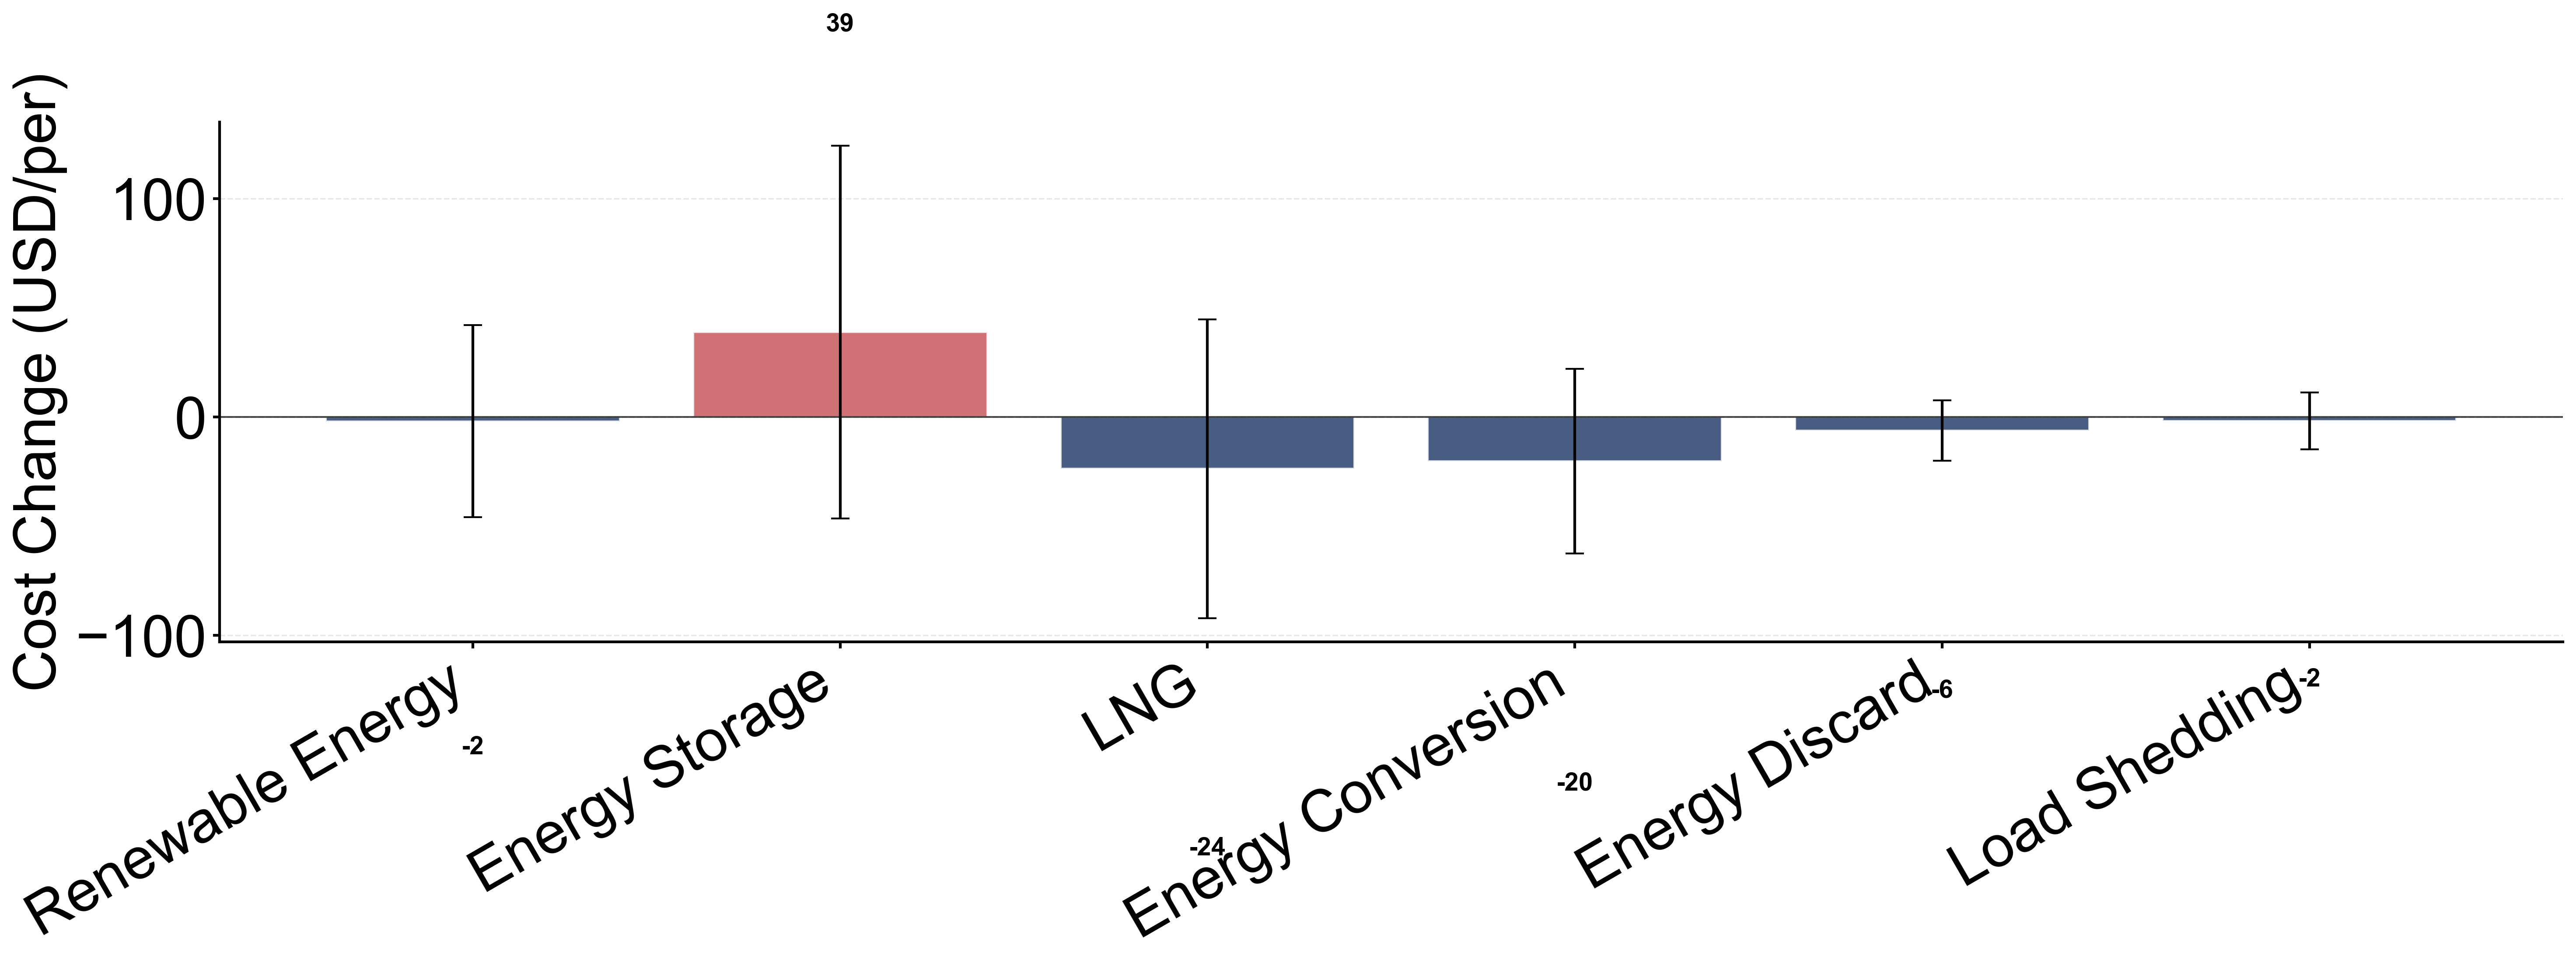

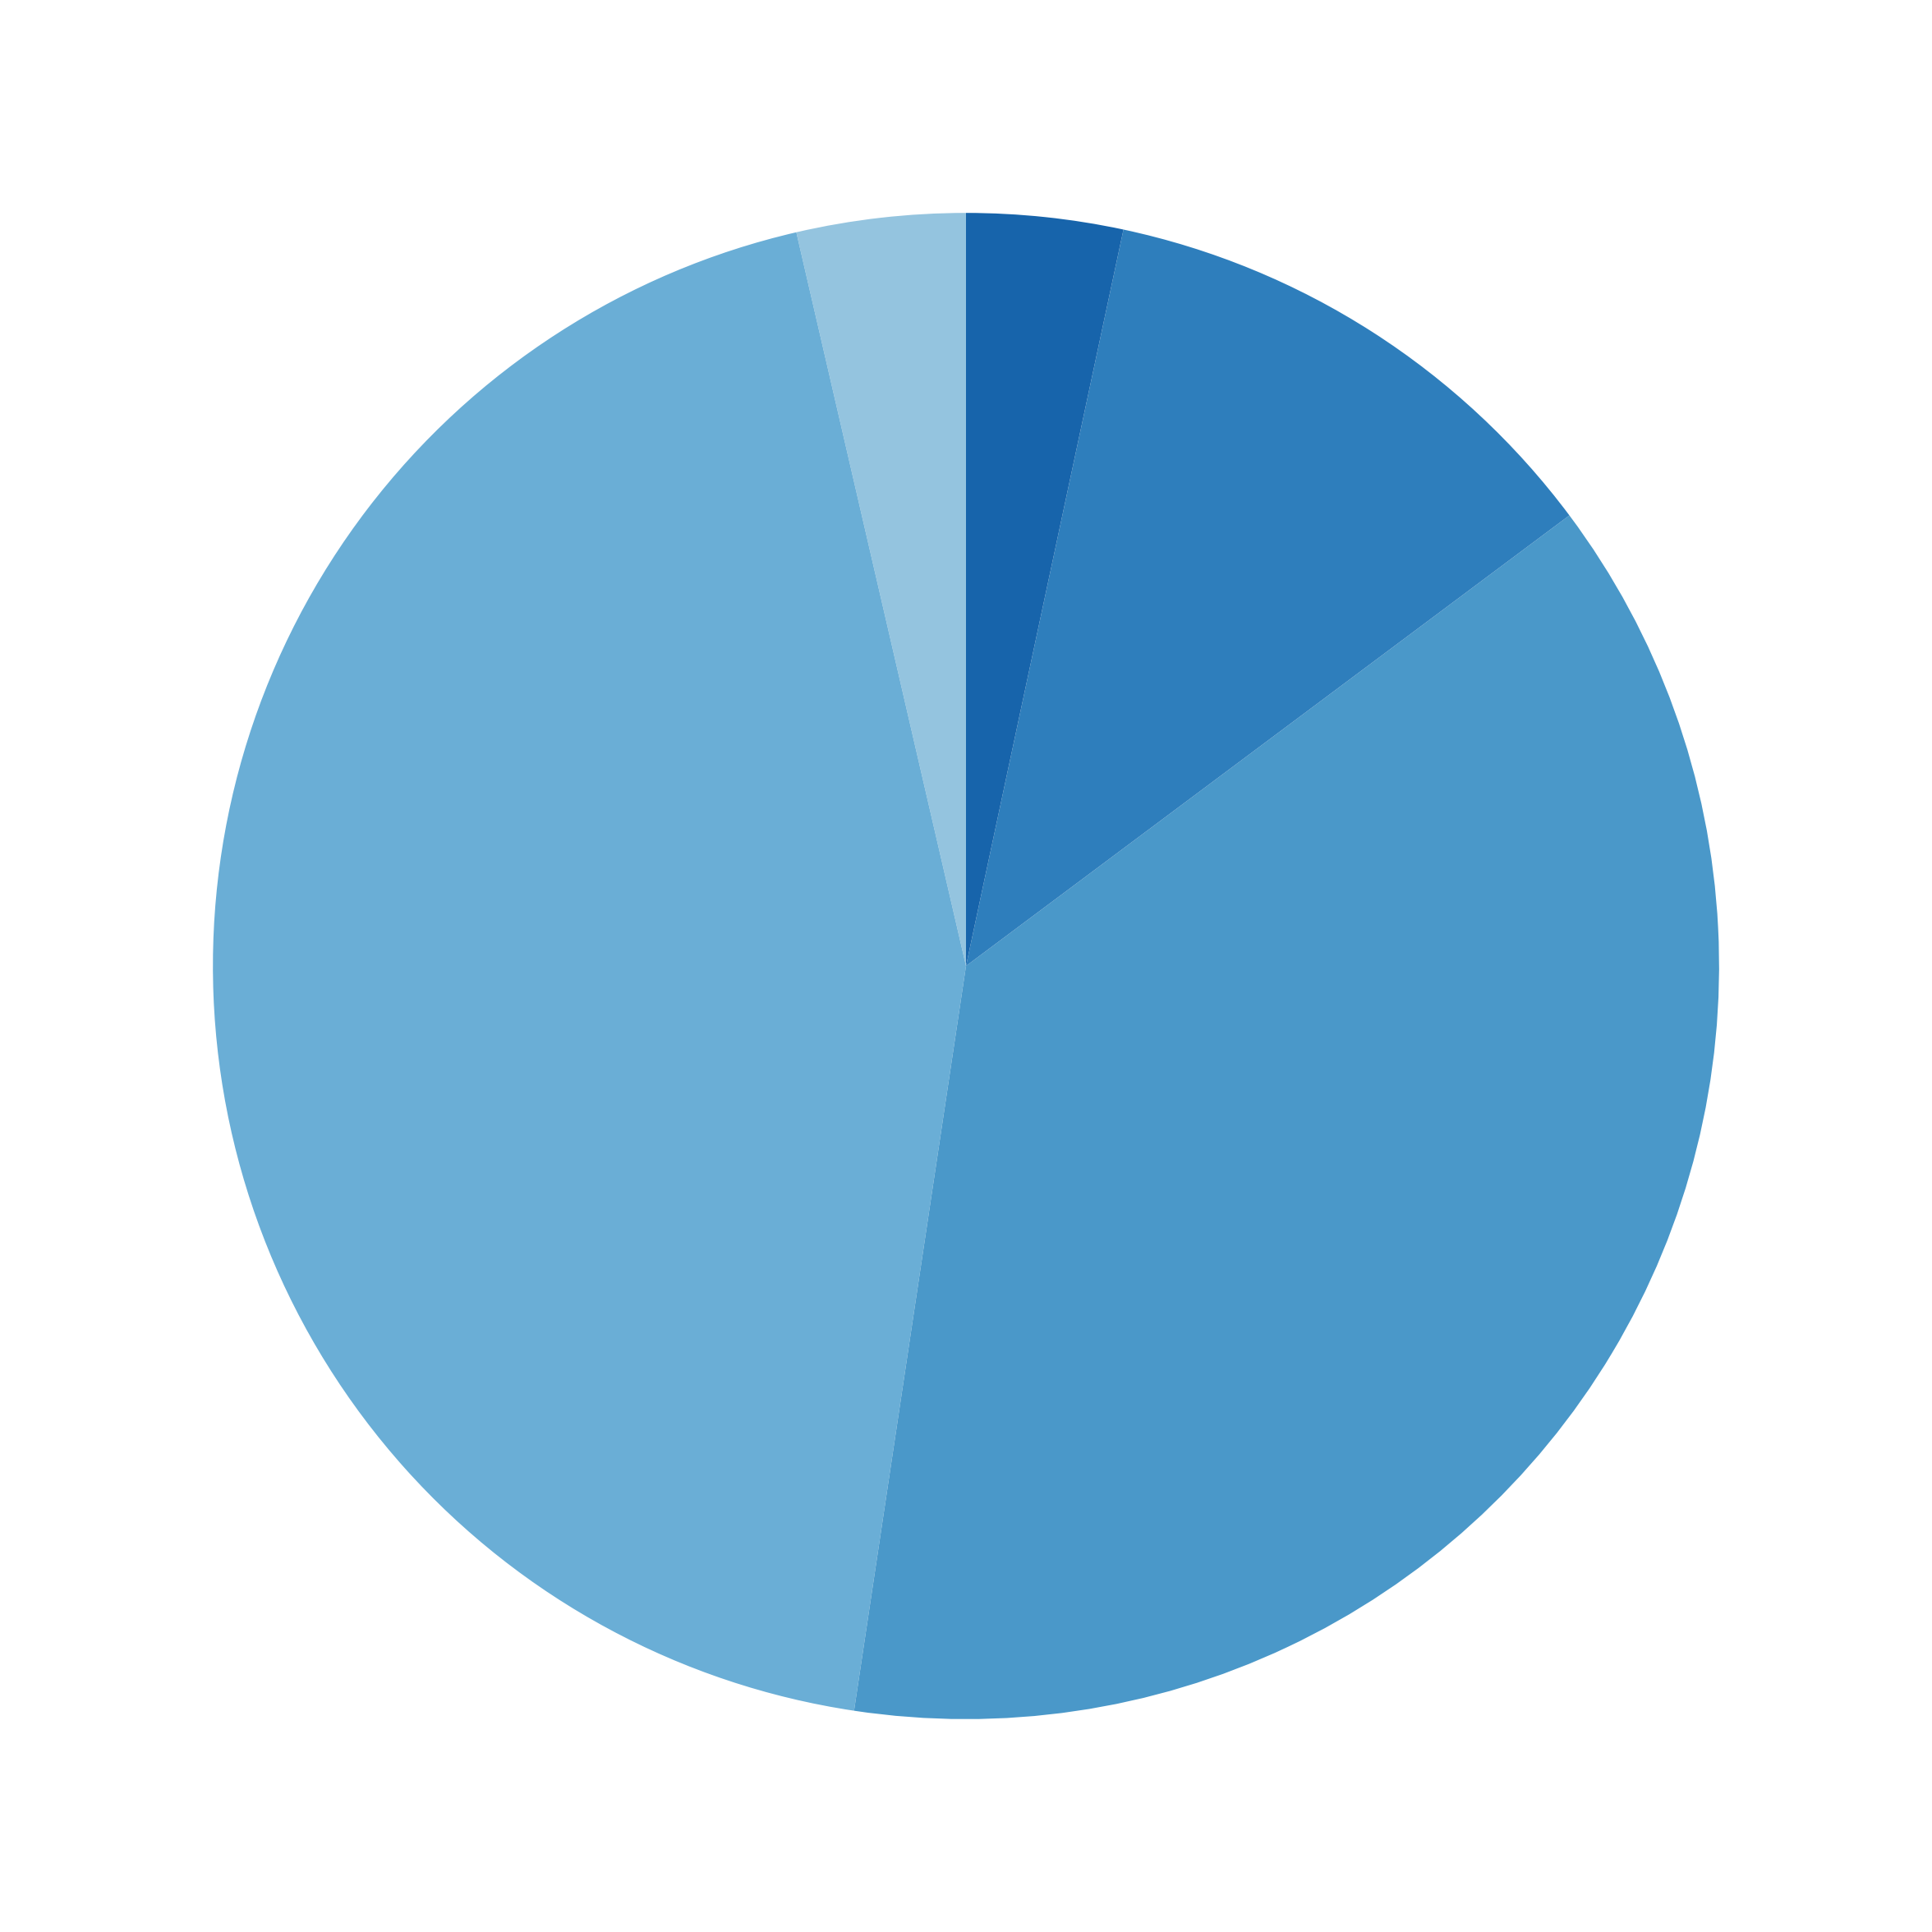


=== 成本降低贡献分析 ===


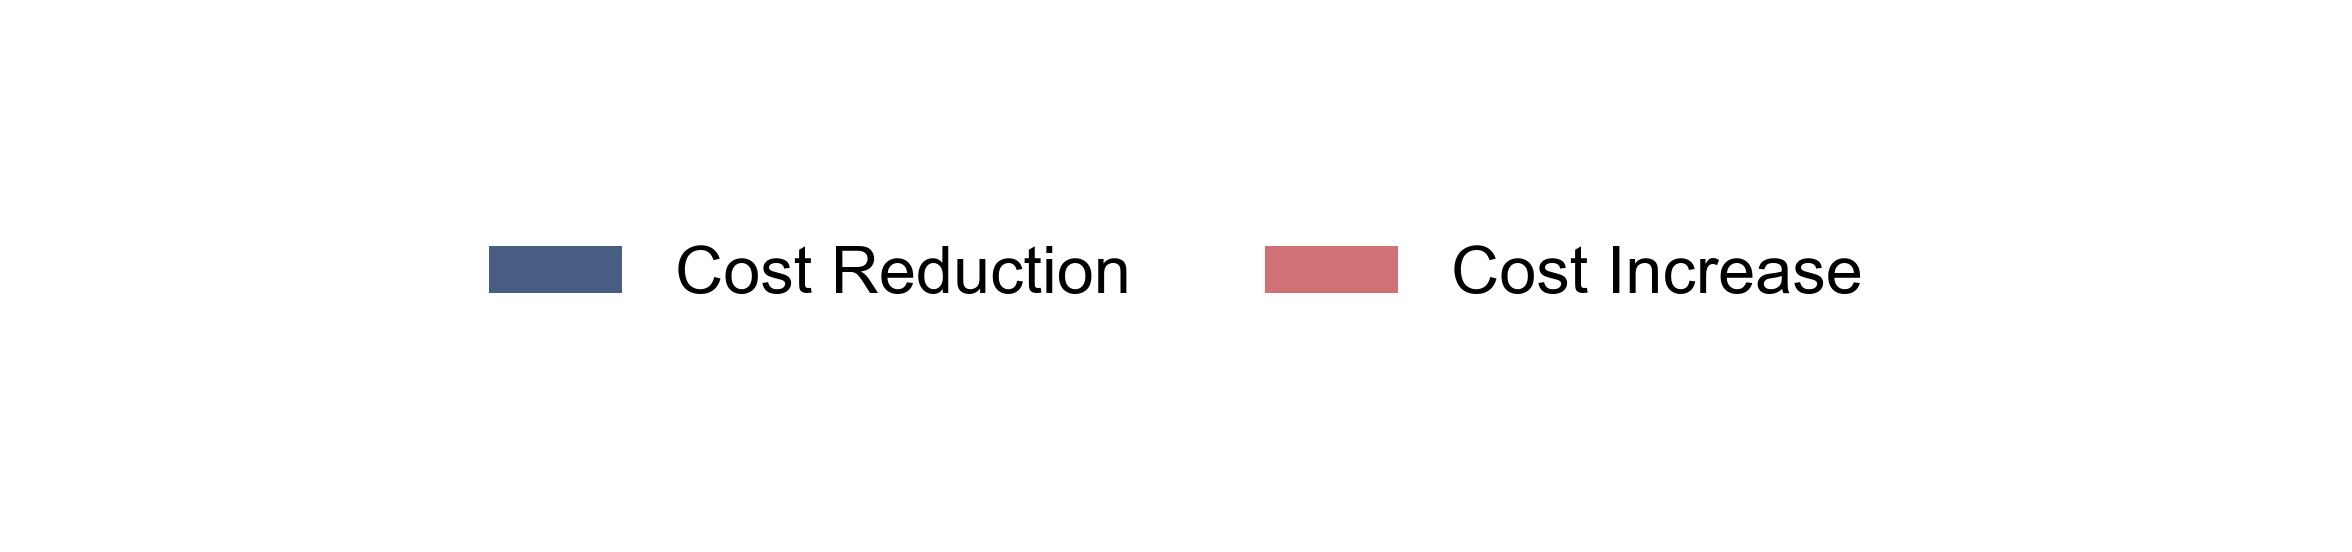

In [76]:
# 8. --- 成本组成部分降低分析：分析哪些成本降低最多 ---



print("开始分析成本显著降低岛屿的各成本组成部分变化...")

# 使用前面已经识别出的有显著成本降低的岛屿
if len(significant_changes) > 0:
    # 获取对应的详细成本数据 - 从成本数据CSV文件中读取
    try:
        # 读取详细成本数据
        df_cost_base = pd.read_csv('island_cost_summary_2050.csv')  # Climate Stress情景
        df_cost_compare = pd.read_csv('island_cost_summary_future_2050.csv')  # TP2050情景
        
        print(f"成本基础数据文件列名: {df_cost_base.columns.tolist()}")
        print(f"成本基础数据形状: {df_cost_base.shape}")
        
        # 成本组成部分列表
        cost_components = [
            'renewable_cost_per_capita',    # 可再生能源成本
            'storage_cost_per_capita',      # 储能成本
            'lng_cost_per_capita',          # LNG成本
            'other_equipment_cost_per_capita',  # 其他设备成本
            'discard_cost_per_capita',      # 弃电成本
            'load_shedding_cost_per_capita' # 负荷削减成本
        ]
        
        # 成本类别的英文显示标签
        cost_labels = [
            "Renewable Energy",     # 可再生能源
            "Energy Storage",       # 储能
            "LNG",                 # LNG
            "Energy Conversion",    # 能源转换设备
            "Energy Discard",      # 弃电
            "Load Shedding"        # 负荷削减
        ]
        
        # 从significant_islands获取经纬度信息（这个变量在前面的cell中已经创建）
        # significant_islands包含了有显著变化的岛屿及其position_change
        significant_coords = significant_islands[['lat', 'lon']].copy()
        
        print(f"有显著成本降低的岛屿坐标数量: {len(significant_coords)}")
        
        # 创建一个匹配函数来根据经纬度找到对应的成本数据
        def match_islands_by_coords(cost_df, coords_df, tolerance=1e-6):
            """根据经纬度匹配岛屿，允许小的数值误差"""
            matched_indices = []
            
            for _, coord_row in coords_df.iterrows():
                target_lat = coord_row['lat']
                target_lon = coord_row['lon']
                
                # 寻找匹配的经纬度（允许小的数值误差）
                lat_match = np.abs(cost_df['lat'] - target_lat) < tolerance
                lon_match = np.abs(cost_df['lon'] - target_lon) < tolerance
                matches = cost_df[lat_match & lon_match]
                
                if not matches.empty:
                    matched_indices.append(matches.index[0])
            
            return cost_df.iloc[matched_indices].copy()
        
        # 筛选有显著成本降低的岛屿的成本数据
        cost_base_filtered = match_islands_by_coords(df_cost_base, significant_coords)
        cost_compare_filtered = match_islands_by_coords(df_cost_compare, significant_coords)
        
        print(f"成本基础数据 (Climate Stress): {len(cost_base_filtered)} 个岛屿")
        print(f"成本对比数据 (TP2050): {len(cost_compare_filtered)} 个岛屿")
        
        # 基于经纬度合并数据进行成本变化计算
        cost_merged = pd.merge(
            cost_base_filtered[['lat', 'lon'] + cost_components],
            cost_compare_filtered[['lat', 'lon'] + cost_components],
            on=['lat', 'lon'], 
            suffixes=('_base', '_compare')
        )
        
        print(f"成功匹配的岛屿数量: {len(cost_merged)}")
        
        if len(cost_merged) > 0:
            # 计算各成本组成部分的变化量 (TP2050 - Climate Stress)
            cost_changes = {}
            for i, component in enumerate(cost_components):
                base_col = f"{component}_base"
                compare_col = f"{component}_compare"
                change_col = f"{component}_change"
                
                cost_merged[change_col] = cost_merged[compare_col] - cost_merged[base_col]
                cost_changes[cost_labels[i]] = cost_merged[change_col].values
            
            # --- 统计分析 ---
            print("\n=== 各成本组成部分变化统计分析 ===")
            cost_stats = {}
            for label, changes in cost_changes.items():
                mean_change = np.mean(changes)
                median_change = np.median(changes)
                std_change = np.std(changes)
                
                cost_stats[label] = {
                    'mean': mean_change,
                    'median': median_change,
                    'std': std_change,
                    'data': changes
                }
                
                print(f"{label}:")
                print(f"  平均变化: {mean_change:.2f} USD/per capita")
                print(f"  中位数变化: {median_change:.2f} USD/per capita")
                print(f"  标准差: {std_change:.2f} USD/per capita")
                print(f"  降低比例: {np.sum(changes < 0) / len(changes) * 100:.1f}%")
            
            # 识别贡献最大的成本类别
            mean_changes = [stats['mean'] for stats in cost_stats.values()]
            max_reduction_idx = np.argmin(mean_changes)  # 最大降低（最负值）
            max_reduction_category = list(cost_stats.keys())[max_reduction_idx]
            max_reduction_amount = mean_changes[max_reduction_idx]
            
            print(f"\n降低最多的成本类别: {max_reduction_category}")
            print(f"平均降低量: {abs(max_reduction_amount):.2f} USD/per capita")
            
            # 计算总体成本降低
            total_cost_change = sum(mean_changes)
            print(f"总体平均成本变化: {total_cost_change:.2f} USD/per capita")
            
            # --- 可视化 1: 成本组成部分变化柱状图 ---
            fig, ax = plt.subplots(figsize=(20, 8), dpi=300)
            
            categories = list(cost_stats.keys())
            means = [cost_stats[cat]['mean'] for cat in categories]
            stds = [cost_stats[cat]['std'] for cat in categories]
            
            # 根据变化量设置颜色：降低用蓝色，增加用红色
            colors = ['#1a3563' if mean < 0 else '#C44E52' for mean in means]
            
            bars = ax.bar(range(len(categories)), means, 
                         yerr=stds,  # 误差线显示标准差
                         capsize=5,  # 误差线帽大小
                         color=colors, 
                         alpha=0.8,  # 透明度
                         edgecolor='white',  # 边框颜色
                         linewidth=1)  # 边框线宽
            
            # 在柱子上添加数值标签
            for i, (bar, mean_val) in enumerate(zip(bars, means)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., 
                       height + (stds[i] if height >= 0 else -stds[i]) + (50 if height >= 0 else -100),
                       f'{mean_val:.0f}',  # 显示整数值
                       ha='center', va='bottom' if height >= 0 else 'top',
                       fontsize=14, fontweight='bold')
            
            # 添加零参考线
            ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
            
            # 设置坐标轴
            ax.set_xticks(range(len(categories)))
            ax.set_xticklabels(categories, rotation=30, ha='right', fontsize=32)
            ax.set_ylabel('Cost Change (USD/per)', fontsize=32)
            ax.tick_params(axis='y', labelsize=32)
            
            # 美化图表
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            
            plt.tight_layout()
            plt.show()
            
            # --- 可视化 2: 成本降低贡献饼图 ---
            # 只考虑有降低贡献的成本类别
            reduction_contributions = {}
            for label, mean_change in zip(categories, means):
                if mean_change < 0:  # 只考虑成本降低的类别
                    reduction_contributions[label] = abs(mean_change)
            
            if reduction_contributions:
                fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
                
                labels = list(reduction_contributions.keys())
                sizes = list(reduction_contributions.values())
                
                # 使用蓝色调色板
                colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(labels)))
                
                # wedges, texts, autotexts = ax.pie(sizes, 
                #                                  labels=labels,
                #                                  autopct='%1.1f%%',  # 显示百分比
                #                                  startangle=90,  # 起始角度
                #                                  colors=colors,
                #                                  textprops={'fontsize': 14})
                wedges = ax.pie(sizes, 
                        startangle=90,
                        colors=colors,
                        textprops={'fontsize': 14})[0] 
                # 设置百分比文字样式
                # for autotext in autotexts:
                #     autotext.set_color('white')
                #     autotext.set_fontweight('bold')
                
                ax.set_aspect('equal')  # 确保饼图为圆形
                plt.tight_layout()
                plt.show()
                
                print(f"\n=== 成本降低贡献分析 ===")
                total_reduction = sum(sizes)
                # for label, contribution in reduction_contributions.items():
                #     percentage = contribution / total_reduction * 100
                #     print(f"{label}: {contribution:.2f} USD/per capita ({percentage:.1f}%)")
            
            # --- 创建单独的图例 ---
            fig_legend, ax_legend = plt.subplots(figsize=(8, 2), dpi=300)
            ax_legend.axis('off')
            
            # 图例元素
            legend_elements = [
                plt.Rectangle((0,0),1,1, facecolor='#1a3563', alpha=0.8, label='Cost Reduction'),  # 成本降低
                plt.Rectangle((0,0),1,1, facecolor='#C44E52', alpha=0.8, label='Cost Increase'),   # 成本增加
                # plt.Line2D([0], [0], color='black', linewidth=1, alpha=0.7, label='Zero Reference Line')  # 零参考线
            ]
            
            legend = ax_legend.legend(handles=legend_elements,
                                    loc='center',  # 居中
                                    frameon=False,  # 无边框
                                    fontsize=16,  # 字体大小
                                    ncol=3,  # 3列
                                    columnspacing=2)  # 列间距
            
            plt.tight_layout()
            plt.show()
            
        else:
            print("警告：没有找到匹配的成本数据")
            
    except FileNotFoundError as e:
        print(f"错误：无法找到成本数据文件 - {e}")
        print("请确保以下文件存在:")
        print("- island_cost_summary_2050.csv") 
        print("- island_cost_summary_future_2050.csv")
    
else:
    print("没有发现显著成本降低的岛屿，跳过成本组成部分分析。")